# Privacy–Utility Trade-off for Code Completion

This notebook measures the trade-off between **privacy** (how different an obfuscated prompt is from the original)
and **utility** (how close the generated completion is to the canonical HumanEval solution) using a small code model.



### Environment setup + Imports

We install all required dependencies and load the libraries used for data handling,
model inference, obfuscation, and evaluation.

In [3]:
%pip install \
    transformers \
    datasets \
    evaluate \
    python-Levenshtein \
    accelerate \
    sentencepiece \
    matplotlib \
    "numpy<2.0" \
    ipywidgets \
    nltk \
    absl-py \
    rouge-score \
    safetensors


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Standard library
import re

# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Hugging Face: datasets + model
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Evaluation
import evaluate
import Levenshtein


### Dataset — first 20 HumanEval test examples

Below is a preview of the first HumanEval test case. 
This is to verify the loading and structure of the prompts the model will receive.

In [6]:
ds = load_dataset("openai/openai_humaneval", split="test")
examples = ds.select(range(20))

ds.select(range(1)).to_pandas()



,task_id,prompt,canonical_solution,test,entry_point
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...",has_close_elements


### Obfuscation strategies (low vs high)

In [8]:
PY_KEYWORDS = {
    "False","None","True","and","as","assert","async","await","break","class","continue",
    "def","del","elif","else","except","finally","for","from","global","if","import",
    "in","is","lambda","nonlocal","not","or","pass","raise","return","try","while","with","yield"
}

PY_BUILTINS_AND_TYPES = {
    "int", "float", "str", "bool", "list", "dict", "set", "tuple",
    "List", "Dict", "Set", "Tuple", "Optional", "Iterable", "Callable"
}

RESERVED_WORDS = PY_KEYWORDS | PY_BUILTINS_AND_TYPES

# Regex patterns
IDENTIFIER_PATTERN = r"\b[_a-zA-Z][_a-zA-Z0-9]*\b"
LINE_COMMENT_PATTERN = r"#.*"
TRIPLE_DOUBLE_DOCSTRING_PATTERN = r'""".*?"""'
TRIPLE_SINGLE_DOCSTRING_PATTERN = r"'''.*?'''"
MULTIPLE_BLANK_LINES_PATTERN = r"\n\s*\n"


def extract_identifiers(code: str):
    toks = re.findall(IDENTIFIER_PATTERN, code)
    ids = []
    for t in toks:
        if t in RESERVED_WORDS:
            continue
        ids.append(t)
    return list(dict.fromkeys(ids))  # unique, preserve order

def rename_identifiers(code: str, mapping: dict):
    def repl(match):
        w = match.group(0)
        # if in the mapping replace, otherwise return original
        return mapping.get(w, w)
    pattern = IDENTIFIER_PATTERN
    return re.sub(pattern, repl, code)

def strip_comments_and_docstrings(code: str):
    code = re.sub(LINE_COMMENT_PATTERN, "", code)
    code = re.sub(TRIPLE_DOUBLE_DOCSTRING_PATTERN, "", code, flags=re.DOTALL)
    code = re.sub(TRIPLE_SINGLE_DOCSTRING_PATTERN, "", code, flags=re.DOTALL)
    return code

def low_obfuscation(prompt: str):
    """
    Low-level obfuscation:
    - Rename user-defined identifiers to short synthetic names (v0, v1, ...)
    - Preserve Python keywords, builtins, and type names
    - Keep comments and docstrings intact

    This aims to hide naming-specific information in the code while keeping structure
    and natural-language descriptions visible.
    """
    # Split into segments: non-docstring, docstring, non-docstring, ...
    parts = re.split(r'(""".*?"""|\'\'\'.*?\'\'\')', prompt, flags=re.DOTALL)

    # Collect identifiers only from the non-docstring parts (even indices)
    code_only = "".join(parts[0::2])
    ids = extract_identifiers(code_only)

    mapping = {}
    var_i = 0
    for name in ids:
        if len(name) <= 1:
            continue
        mapping[name] = f"v{var_i}"
        var_i += 1

    # Apply renaming only to the non-docstring parts
    for i in range(0, len(parts), 2):
        parts[i] = rename_identifiers(parts[i], mapping)

    # Docstring parts (odd indices) are left untouched
    return "".join(parts)

def high_obfuscation(prompt: str):
    """
    High-level obfuscation:
    - Replace user-defined identifiers with placeholders (X0, X1, ...)
    - Strip comments and docstrings
    - Optionally remove type hints or whitespace cues

    This removes most human-readable, semantic hints from the prompt while preserving syntactic structure.
    """
    p = strip_comments_and_docstrings(prompt)
    ids = extract_identifiers(p)
    mapping = {name: f"X{i}" for i, name in enumerate(ids)}
    p = rename_identifiers(p, mapping)
    p = re.sub(MULTIPLE_BLANK_LINES_PATTERN, "\n", p)
    return p


**Example (example_id = 0)**

- Original prompt: `def has_close_elements(numbers: List[float], threshold: float) -> bool: ...`
- Low obfuscation: `def v1(v2: List[float], v3: float) -> bool: ...`
- High obfuscation: `def X1(X2: List[float], X3: float) -> bool: ...`


In [10]:
# Load tokenizer and model (using safetensors weights)
model_name = "Salesforce/codet5-small"
tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    use_safetensors=True, 
)

# Helper function: generate a deterministic completion from a code prompt
def complete(prompt: str, max_new_tokens=128):
    inputs = tok(prompt, return_tensors="pt", truncation=True)
    out = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    return tok.decode(out[0], skip_special_tokens=True)


**Utility metric.**  
We use the Hugging Face `evaluate` implementation of the ROUGE metric. For each example we compute ROUGE between
the generated completion and the canonical HumanEval `canonical_solution`. This gives a token-overlap-based
approximation of how close the model's completion is to the reference.

**Privacy metric.**  
We measure privacy as the normalized Levenshtein distance between the original prompt and each obfuscated variant:

$$
\text{privacy}(p_{\text{orig}},\, p_{\text{var}}) \;=\;
\frac{\text{Levenshtein}(p_{\text{orig}},\, p_{\text{var}})}
     {\max(|p_{\text{orig}}|,\, |p_{\text{var}}|)}
$$

Levenshtein distance counts the minimum number
of character edits (insertions, deletions, substitutions) required to transform one
string into another, so larger distances correspond to stronger obfuscation.

To make the score independent of prompt length, we divide by the maximum length of
the two strings, giving a value in the range \([0, 1]\). A score of **0** means the
prompts are identical, while a score of **1** indicates maximal difference.


In [12]:
rouge = evaluate.load("rouge")

def utility_score(generated: str, canonical: str):
    scores = rouge.compute(predictions=[generated], references=[canonical])
    return scores["rougeL"]

def privacy_score(prompt_variant: str, prompt_orig: str):
    dist = Levenshtein.distance(prompt_variant, prompt_orig)
    return dist / max(len(prompt_variant), len(prompt_orig))


### Generating completions and computing scores

We combine all completions (original, low-obfuscated, high-obfuscated) into a single
DataFrame with 60 rows (20 examples × 3 variants). Below we show the first few rows
as a sanity check to confirm the structure.


In [14]:
rows = []

for i, ex in enumerate(examples):
    prompt_orig = ex["prompt"]
    canonical = ex["canonical_solution"]

    prompt_low = low_obfuscation(prompt_orig)
    prompt_high = high_obfuscation(prompt_orig)

    comp_orig = complete(prompt_orig)
    comp_low = complete(prompt_low)
    comp_high = complete(prompt_high)

    for name, p, comp in [
        ("original", prompt_orig, comp_orig),
        ("low", prompt_low, comp_low),
        ("high", prompt_high, comp_high),
    ]:
        rows.append({
            "example_id": i,
            "variant": name,
            "prompt": p,
            "completion": comp,
            "utility": utility_score(comp, canonical),
            "privacy": privacy_score(p, prompt_orig),
        })

df = pd.DataFrame(rows)
df.head()


,example_id,variant,prompt,completion,utility,privacy
0,0,original,from typing import List\n\n\ndef has_close_ele...,"has_close_elements(numbers: List[float], thres...",0.090909,0.000000
1,0,low,from v0 import List\n\n\ndef v1(v2: List[float...,"has_close_elements([1.0, 2.8,0.5)\n 0.5)\n ...",0.000000,0.114943
2,0,high,"from X0 import List\ndef X1(X2: List[float], X...",:,0.000000,0.839080
3,1,original,from typing import List\n\n\ndef separate_pare...,**********************************************...,0.000000,0.000000
4,1,low,from v0 import List\n\n\ndef v1(v2: str) -> Li...,(v1: str):\n (v2:)()))))))))))))))))))))),0.000000,0.077075


### Summary statistics and privacy–utility correlation

To get an overall view of the effect of obfuscation, we compute:

- the **mean privacy** and **mean utility** for each variant (original / low / high)
- the **Pearson correlation coefficient** between privacy and utility across all 60 datapoints

A negative correlation indicates that higher privacy generally corresponds to lower utility.


In [16]:
summary = df.groupby("variant")[["privacy", "utility"]].mean()
display(summary)

corr = df["privacy"].corr(df["utility"])
print(f"Pearson correlation between privacy and utility: {corr:.2f}")



,privacy,utility
variant,,
high,0.870046,0.003846
low,0.084596,0.021235
original,0.000000,0.053314


Pearson correlation between privacy and utility: -0.31


### Visualising the privacy–utility trade-off

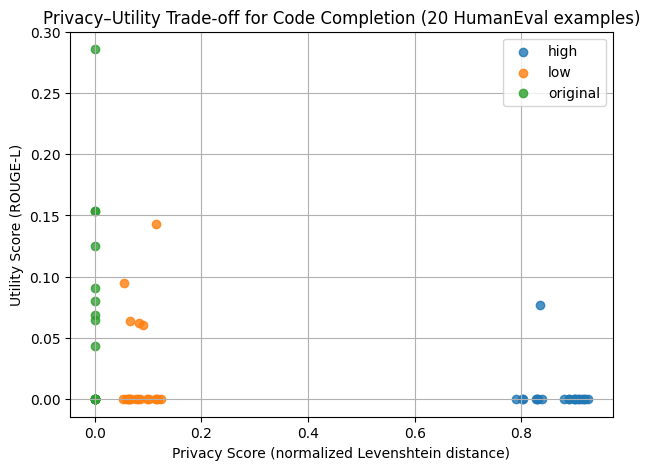

In [18]:
plt.figure(figsize=(7,5))

for v, sub in df.groupby("variant"):
    plt.scatter(sub["privacy"], sub["utility"], label=v, alpha=0.8)

plt.xlabel("Privacy Score (normalized Levenshtein distance)")
plt.ylabel("Utility Score (ROUGE-L)")
plt.title("Privacy–Utility Trade-off for Code Completion (20 HumanEval examples)")
plt.legend()
plt.grid(True)
plt.show()


## Analysis

The results show a clear privacy–utility trade-off across the 60 runs (20 tasks × 3 variants).

On average, **original prompts** have a privacy score of 0.00 and the highest utility (\~0.053), since they preserve all semantic and structural information. Applying **low obfuscation** (identifier renaming) increases privacy to \~0.085 but reduces utility to \~0.021, suggesting that model performance already depends on the specific identifier names used in the prompt. With **high obfuscation**, privacy rises further to \~0.87 while utility drops close to zero (\~0.0038), indicating that removing meaningful names, comments, and docstrings makes the prompt much less informative for the model.

The Pearson correlation between privacy and utility over all 60 points is -0.31 (negative), reinforcing the observed trade-off.

The scatter plot therefore exhibits a clear negative relationship between privacy and utility: as we make prompts more private by aggressively obfuscating them, the model’s completions share fewer n-grams with the canonical solutions.

**Limitations.** This analysis uses a relatively small model and only the first 20 HumanEval test examples, so the absolute scores are low and may not generalise to larger models. In addition, ROUGE and character-level Levenshtein distance are only proxies for true functional correctness and privacy; two prompts with similar structure might still reveal sensitive semantics. Nevertheless, the experiment illustrates the qualitative trade-off that stronger obfuscation improves privacy at the cost of completion quality. Note that the low-obfuscation setting still leaks some semantic information via docstring examples (e.g. the original function name appears inside >>> lines), whereas the high-obfuscation setting removes these entirely. As a result, the privacy scores for low obfuscation reflect only identifier changes in code, not comment-level leakage.

